## Câu 1: Hãy viết câu lệnh SQLđể tính sự tương quan giữaAvà B theo công thức sau:
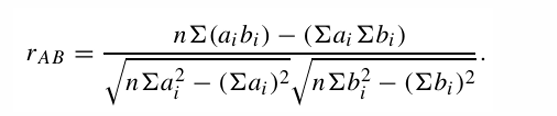


In [5]:
import sqlite3
import math

# Kết nối với database
conn = sqlite3.connect('Database_c3.db')
cursor = conn.cursor()

# Tạo bảng (nếu chưa tồn tại)
cursor.execute("""
CREATE TABLE IF NOT EXISTS MyTable (
    A REAL,
    B REAL
)
""")

# Xoá dữ liệu cũ trong bảng (cho sạch sẽ khi chạy lại nhiều lần)
cursor.execute("DELETE FROM MyTable")

# Chèn dữ liệu ví dụ vào bảng
data = [
    (8, 6),
    (2, 0),
    (0, 4),
    (2, 1),
    (2, 8)
]
cursor.executemany("INSERT INTO MyTable (A, B) VALUES (?, ?)", data)
conn.commit()

# Câu lệnh SQL tính hệ số tương quan
query = """
SELECT 
    (COUNT(*) * SUM(A * B) - (SUM(A) * SUM(B))) / 
    (SQRT(COUNT(*) * SUM(A * A) - SUM(A) * SUM(A)) * 
     SQRT(COUNT(*) * SUM(B * B) - SUM(B) * SUM(B))) AS correlation
FROM MyTable
"""

cursor.execute(query)
result = cursor.fetchone()[0]
print(f"Hệ số tương quan: {result}")

# Đóng kết nối
conn.close()


Hệ số tương quan: 0.31524416249564025


### Câu 2: Một công ty oto đang kiểm tra 3 loại mẫu mới A, B và C trong 4 ngày, và chấm điểm theo thang từ 1 đến 10 điểm cho mỗi ngày với bảng sau. Liệu có sự khác biệt đáng kể giữa các mẫu dựa trên điểm số mà chúng nhận được trong 4 ngày thử nghiệm không? Kết quả thử nghiệm phụ thuộc vào ngày hay phụ thuộc vào mẫu xe? Hãy chuyển đổi dữ liệu sang dạng quan hệ và thực hiện kiểm tra χ2

#### Chuyển đổi dữ liệu sang dạng quan hệ

In [ ]:
import sqlite3

# Kết nối CSDL
conn = sqlite3.connect('car_scores.db')
cursor = conn.cursor()

# Tạo bảng (nếu chưa có)
cursor.execute('''
    CREATE TABLE IF NOT EXISTS Bang2 (
        Day TEXT,
        Model TEXT,
        Score REAL
    )
''')

# Dữ liệu cần chèn
data = [
    ('Day1', 'A', 8), ('Day1', 'B', 9), ('Day1', 'C', 7),
    ('Day2', 'A', 7.5), ('Day2', 'B', 8.5), ('Day2', 'C', 7),
    ('Day3', 'A', 6), ('Day3', 'B', 7), ('Day3', 'C', 8),
    ('Day4', 'A', 7), ('Day4', 'B', 6), ('Day4', 'C', 5)
]

# Thêm dữ liệu mới
cursor.executemany("INSERT INTO Bang2 VALUES (?, ?, ?)", data)

# Lấy dữ liệu và in ra
cursor.execute("SELECT * FROM Bang2")
rows = cursor.fetchall()
for row in rows:
    print(row)

conn.commit()
conn.close()


('Day1', 'A', 8.0)
('Day1', 'B', 9.0)
('Day1', 'C', 7.0)
('Day2', 'A', 7.5)
('Day2', 'B', 8.5)
('Day2', 'C', 7.0)
('Day3', 'A', 6.0)
('Day3', 'B', 7.0)
('Day3', 'C', 8.0)
('Day4', 'A', 7.0)
('Day4', 'B', 6.0)
('Day4', 'C', 5.0)


####  thực hiện kiểm tra χ2

In [ ]:
import sqlite3
import pandas as pd

# Kết nối đến SQLite database
conn = sqlite3.connect('Database_c3.db')
cursor = conn.cursor()

# B Tạo bảng Bang2_Cat có thêm cột 'Category' phân loại theo Score
cursor.executescript("""

-- Tạo bảng mới Bang2_Cat từ Bang2 và thêm cột Category
CREATE TABLE Bang2_Cat AS
SELECT *,
    CASE
        WHEN Score <= 6 THEN 'Low'
        WHEN Score <= 8 THEN 'Medium'
        ELSE 'High'
    END AS Category
FROM Bang2;
""")

#  Tính thống kê Chi-squared 
query = """
WITH 
-- Tính tần suất thực tế (Observed) theo Day và Category
Observed AS (
    SELECT Day, Category, COUNT(*) AS observed
    FROM Bang2_Cat
    GROUP BY Day, Category
),

-- Tính tổng số dòng theo từng Day
RowTotals AS (
    SELECT Day, COUNT(*) AS row_total
    FROM Bang2_Cat
    GROUP BY Day
),

-- Tính tổng số cột theo từng Category
ColTotals AS (
    SELECT Category, COUNT(*) AS col_total
    FROM Bang2_Cat
    GROUP BY Category
),

--  Tính tổng toàn bảng
GrandTotal AS (
    SELECT COUNT(*) AS grand_total FROM Bang2_Cat
),

--  Tính giá trị kỳ vọng (expected) theo công thức:
-- expected = (row_total * col_total) / grand_total
ExpectedTable AS (
    SELECT 
        O.Day,
        O.Category,
        O.observed,
        (R.row_total * C.col_total * 1.0) / G.grand_total AS expected
    FROM Observed O
    JOIN RowTotals R ON O.Day = R.Day
    JOIN ColTotals C ON O.Category = C.Category
    JOIN GrandTotal G
)

-- Tính thống kê Chi-squared theo công thức:
-- SUM((observed - expected)^2 / expected)
SELECT SUM(
    ((observed - expected) * (observed - expected)) / expected
) AS chi_squared
FROM ExpectedTable;
"""

# Thực thi truy vấn và lấy kết quả thống kê Chi-squared
cursor.execute(query)
chi_squared = cursor.fetchone()[0]

# In kết quả
print(f"Chi-squared statistic: {chi_squared}")

# Đóng kết nối SQLite
conn.close()


Chi-squared statistic: 3.5952380952380953


H0 (giả thuyết không): Không có mối liên hệ giữa "Day" và "Category" (phân phối điểm số đồng đều giữa các ngày).

H1 (giả thuyết đối): Có mối liên hệ giữa "Day" và "Category" (điểm số phụ thuộc vào ngày thử nghiệm).

In [8]:
from scipy.stats import chi2
alpha = 0.05
critical_value = chi2.ppf(1 - alpha, df=6) #(df) = (số hàng - 1) × (số cột - 1)
print(f"Chi-squared critical value (α=0.05, df=6): {critical_value}")


Chi-squared critical value (α=0.05, df=6): 12.591587243743977


Do chi statistic< chi value .Suy ra không đủ bằng chứng để bác bỏ H0

Không có sự khác biệt đáng kể giữa các mẫu điểm số theo từng ngày.

Kết quả thử nghiệm không phụ thuộc vào ngày – tức là điểm số của các mẫu xe không thay đổi có ý nghĩa giữa các ngày thử nghiệm.

### Câu 3: Bảng flights(departure_time,…) chứa các giá trị thời gian dưới dạng số nguyên (ví dụ: 830 cho 8:30AM, 1445 cho 2:45 PM). Hãy chuyển đổi các giá trị này thành định dạng thời gian

In [9]:
import sqlite3
import pandas as pd

# Kết nối hoặc tạo mới cơ sở dữ liệu SQLite
conn = sqlite3.connect("Database_c3.db")
cursor = conn.cursor()

# Tạo bảng 
cursor.execute("""
    CREATE TABLE thoigian (
        id INTEGER PRIMARY KEY,
        departure_time INTEGER
    )
""")

# (2) Thêm dữ liệu ví dụ
sample_data = [
    (830,), (1445,), (30,), (1230,), (905,)
]
cursor.executemany("INSERT INTO thoigian (departure_time) VALUES (?)", sample_data)
conn.commit()

# (3) Truy vấn và chuyển định dạng departure_time thành HH:MM
query = """
    SELECT 
        id,
        departure_time,
        printf('%02d:%02d', departure_time / 100, departure_time % 100) AS departure_time_formatted
    FROM thoigian
"""

df = pd.read_sql_query(query, conn)

# (4) Hiển thị kết quả
print(df)

conn.close()


   id  departure_time departure_time_formatted
0   1             830                    08:30
1   2            1445                    14:45
2   3              30                    00:30
3   4            1230                    12:30
4   5             905                    09:05


### Câu 4: Viết truy vấn SQL để tìm các ngoại lệ bằng cách sử dụng MAD. Một quy tắc chung là xem xét các giá trị ngoại lệ lớn hơn 1,5 lần so với giá trị MAD, trong đó x là số độ lệch chuẩn mà ta coi là có ý nghĩa

In [10]:
import sqlite3
import pandas as pd

# Tạo database mới
conn = sqlite3.connect("mad_numeric.db")
cursor = conn.cursor()

# Tạo bảng chỉ có số
cursor.execute("DROP TABLE IF EXISTS Scores")
cursor.execute("""
    CREATE TABLE Scores (
        id INTEGER PRIMARY KEY,
        score REAL
    )
""")

# Chèn dữ liệu điểm số
scores = [
    (1, 5),
    (2, 8),
    (3, 9),
    (4, 10),
    (5, 6),
    (6, 20),    
    (7, 7),
    (8, 6),
    (9, 8),
    (10, 7)
]
cursor.executemany("INSERT INTO Scores VALUES (?, ?)", scores)
conn.commit()

# Bước 1: Tính median
median_query = """
SELECT AVG(score) AS median_score
FROM (
    SELECT score
    FROM Scores
    ORDER BY score
    LIMIT 2 - (SELECT COUNT(*) FROM Scores) % 2
    OFFSET (SELECT (COUNT(*) - 1) / 2 FROM Scores)
) AS MedianSub
"""
median_score = cursor.execute(median_query).fetchone()[0]

# Bước 2: Tính MAD
mad_query = f"""
SELECT AVG(ABS(score - {median_score})) AS mad_value
FROM Scores
"""
mad_value = cursor.execute(mad_query).fetchone()[0]

# Bước 3: Tìm giá trị ngoại lệ
outlier_query = f"""
SELECT *
FROM Scores
WHERE ABS(score - {median_score}) > 1.5 * {mad_value}
"""
df_outliers = pd.read_sql_query(outlier_query, conn)

# In kết quả
print(f"Median: {median_score}")
print(f"MAD: {mad_value}")
print("\nNgoại lệ (outliers):")
print(df_outliers)

conn.close()


Median: 7.5
MAD: 2.4

Ngoại lệ (outliers):
   id  score
0   6   20.0


### Câu 5: Hãy xác định liệu hai người trong bảng Patient(last_name, weight, height) có phải là một người hay không bằng cách sử dụng khoảng cách kết hợp Boolean trên “last_name” và “weight”

In [13]:
import sqlite3
import pandas as pd

# Kết nối tới CSDL SQLite
conn = sqlite3.connect("patients_boolean.db")
cursor = conn.cursor()

# Tạo bảng Patient và thêm dữ liệu mẫu
cursor.execute("DROP TABLE IF EXISTS Patient")
cursor.execute("""
    CREATE TABLE Patient (
        last_name TEXT,
        weight REAL,
        height REAL
    )
""")

data = [
    ('Lan', 60, 160),
    ('Lan', 60, 165),
    ('Mai', 55, 165),
    ('Trang', 60, 160),
    ('Lan', 58, 160)
]
cursor.executemany("INSERT INTO Patient VALUES (?, ?, ?)", data)
conn.commit()

query = """
SELECT 
    p1.rowid AS id1,
    p2.rowid AS id2,
    p1.last_name, p1.weight, p1.height,
    p2.last_name, p2.weight, p2.height,

    CASE WHEN p1.last_name = p2.last_name THEN 1 ELSE 0 END AS match_name,
    CASE WHEN p1.weight = p2.weight THEN 1 ELSE 0 END AS match_weight,

    (CASE WHEN p1.last_name = p2.last_name THEN 1 ELSE 0 END + 
     CASE WHEN p1.weight = p2.weight THEN 1 ELSE 0 END) / 2.0 AS match_score

FROM Patient p1
JOIN Patient p2 ON p1.rowid < p2.rowid
WHERE (CASE WHEN p1.last_name = p2.last_name THEN 1 ELSE 0 END + 
       CASE WHEN p1.weight = p2.weight THEN 1 ELSE 0 END) / 2.0 >= 0.7;
"""

# Đọc kết quả vào DataFrame
df_matches = pd.read_sql_query(query, conn)

# In kết quả
print("Các cặp bệnh nhân có khả năng là cùng một người:")
print(df_matches)

conn.close()


Các cặp bệnh nhân có khả năng là cùng một người:
   id1  id2 last_name  weight  height last_name  weight  height  match_name  \
0    1    2       Lan    60.0   160.0       Lan    60.0   165.0           1   

   match_weight  match_score  
0             1          1.0  
